# Building Load Forecasting with Transformers

This tutorial demonstrates the use of building energy load forecasting using a Transformer.

# Transformers

The transformer, a revolutionary neural network architecture published by Google Brain in their paper [Attention is All You Need](https://arxiv.org/pdf/1706.03762), has made rapid improvements in the Natural Langauge Processing (NLP) domain and is the base for various current state-of-the-art models like BERT, ChatGPT-3, and ChatGPT-4. The main novelty of the Transformer is the multi-headed attention mechanism, that is, the ability of a model to pay _attention_ to important parts of a sentence (or sequential input). Previously, the predecessors of the Transformer in NLP, including a gated recurrent neural network (RNN) and Long Short-term Memory (LSTM), suffered from the [vanishing-gradient problem](https://en.wikipedia.org/wiki/Vanishing_gradient_problem) or the ability to maintain stable gradients with long sequences or sentences. Fortunately, the Transformer has proven to perform well for long sequences due to the parallelization of token processing (or word embedding).

![image.png](https://www.comet.com/site/wp-content/uploads/2023/07/Screen-Shot-2023-07-16-at-4.37.05-PM-2048x851.png)

<!-- 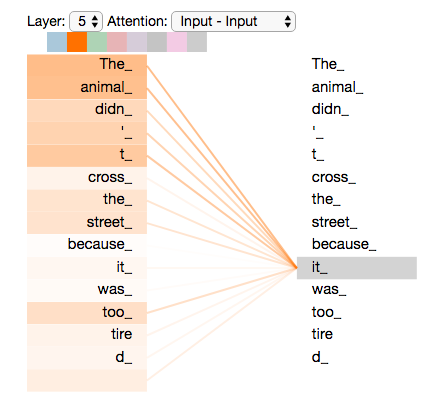 -->

 ## Positional Encoding

In order for the Transformer to make use of the order of the sequence, we must inject some information about the relative or absolute position of the tokens (words) in the sequence. To calculate positonal embeddings of a sequence, we use:


\begin{aligned}
\text{PE}(pos, 2i) = \sin(pos/10000^{2i/d_\text{model}}) \\
\text{PE}(pos, 2i+1) = \cos(pos/10000^{2i/d_\text{model}}) \\
\end{aligned}


where $pos$ is the position and $i$ is the dimension. That is, each dimension of the positional encoding corresponds to a sinusoid. The wavelengths form a geometric progression from $2\pi$ - 10000 $\times$ $2\pi$. Therefore, the final input to the model is the element-wise addition of the positional encoding and the word embedding vector (by passing sequence to nn.Embedding, for example). For more information about positional encoding in the Transformer, visit [transformer positional encoding](https://kikaben.com/transformers-positional-encoding/).

## Self-Attention

As aforementioned, the integration of self-attention in deep learning (DL) models enables the model to produce contextual understanding of each word in a sentence. 
For example, consider the sentence: 

<p style="text-align: center;"><code style="color : darkorange">"The animal didn't cross the street because it was too tired"</code>
</p>

What is "it" referring to? Is it referring to the street or the animal? How does a model learn to associate "it" with "animal"? The Transformer is able to create contextual tokens for words that reference another by creating three vectors from the input vector: Queries, Keys, and Values. These weight matrices can be calculated by first generating a matrix from the input embeddings, <code style="color : green">X</code>,
where every row in <code style="color : green">X</code> matrix corresponds to a word in the input sentence. Then, we multiply the input embedding matrix by the weight matrices (<code style="color : purple">WQ</code>,<code style="color : orange">WK</code>,<code style="color : blue">WV</code>).  These weight matrices are initially randomly initiated but is learned over time during the training process.

Each word is then expressed in terms of the softmax score, that is, quantifying how much a word is related to every other word in the sequence.

<img src="./figs/Transformer_architecture.png" width="500">  

## Encoder and Decoder


Revisiting the end-to-end architecture of a vanilla transformer, the transformer typically includes an encoder and decoder, and both comprise of self-attention blocks.

![image.png](https://kikaben.com/transformers-encoder-decoder/images/encoder-decoder.png). 
* _encoder_ : extracts features from an input sentence
* _decoder_:  uses the features to generate an output sentence (translation).

Putting all of this together, the output of the last layer of the encoder (the features) is then transformed into a set of attention vectors K and V. These are to be used by each decoder in its “encoder-decoder attention” layer which helps the decoder focus on the right places in the input sequence:

![Alt Text](https://jalammar.github.io/images/t/transformer_decoding_1.gif)
![Alt Text](https://jalammar.github.io/images/t/transformer_decoding_2.gif)


## Electricity Load Modelling and Load Forecasting: Ensuring supply meets energy demand

As renewable energy resources increase, ensuring sustainability demands efficient energy management and power system dispatching. Additionally, integrating the energy resources within the distributed system require analytics of energy load forecasting. To that end, intentional and informed decision making necessitates accurate predictions of future energy demand and loads at the aggregate and individual building level. Given the complex relationship of several different parameters such as time of the day, previous electricity demand trends, weather, humidity, electricity price, etc., machine learning and deep learning approachs for energy load forecasting has proven to be an effective method for fitting nonlinear relationships of input data.

While the Transformer's initial implementation was for the domain space of NLP, Transformers have since contributed to a breadth of novel research across diverse subject areas, especially for sequential or time-series data. Previous research in the building energy space has shown that Transformers have outperformed previous deep learning models in electricity load consumption forecasting. In this tutorial, we will demonstrate a use-case of energy load modelling using historical weather features as well as energy load forecasting capabilities using a base Transformer model, with a simplified decoder (linear layer).


## References

 [1] [Vaswani, A., Shazeer, N., Parmar, N., Uszkoreit, J., Jones, L., Gomez, A. N., Kaiser, L., & Polosukhin, I. (2023, August 2). Attention is all you need. arXiv.org. https://doi.org/10.48550/arXiv.1706.03762 ](https://doi.org/10.48550/arXiv.1706.03762 )
 
 [2] [Explainable AI: Visualizing Attention in Transformers](https://www.comet.com/site/blog/explainable-ai-for-transformers/)
 
 [3] [The Illustrated Transformer](https://jalammar.github.io/illustrated-transformer/)

 [4] [Transformer — Attention Is All You Need Easily Explained With Illustrations](https://luv-bansal.medium.com/transformer-attention-is-all-you-need-easily-explained-with-illustrations-d38fdb06d7db)

 [5] [H. S. Oliveira and H. P. Oliveira, “Transformers for Energy Forecast,” Sensors, vol. 23, no. 15, p. 6840, Aug. 2023](https://doi.org/10.3390/s23156840.)
 
 [6] https://kikaben.com/transformers-encoder-decoder/

 [7] J. Kang and D. Reiner, “What is the effect of weather on household electricity consumption? Empirical evidence from Ireland,” Energy Economics, p. 106023, Apr. 2022, doi: https://doi.org/10.1016/j.eneco.2022.106023.

# NeuroMANCER and Dependencies

In [1]:
 # !pip install neuromancer

## Imports

In [3]:
import matplotlib.pyplot as plt
import datetime
from datetime import datetime
from IPython.display import display,clear_output
import numpy as np
from joblib import dump,load
import random
import pandas as pd
import time
import matplotlib.dates as dates
from pathlib import Path 
from sklearn.preprocessing import MinMaxScaler
import os
import requests

import pydot
import torch
import torch.nn as nn
from torch.utils.data import dataset
from torch.nn import TransformerEncoder, TransformerEncoderLayer
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from torch.utils.data.dataloader import default_collate
from torch import Tensor
torch.manual_seed(0);

from neuromancer.psl import plot
from neuromancer import psl
from neuromancer.system import Node, System
from neuromancer.dynamics import integrators
from neuromancer.trainer import Trainer
from neuromancer.problem import Problem
from neuromancer.loggers import BasicLogger
from neuromancer.dataset import *
from neuromancer.constraint import variable, Loss,Objective
from neuromancer.loss import PenaltyLoss
from neuromancer.modules import blocks

## Import Data

For this tutorial, we will be using the [Short-term electricity load forecasting (Panama case study)](https://data.mendeley.com/datasets/byx7sztj59/1) open dataset. The dataset consists of official forecasts from the daily post-disbatch reports from the grid operator with hour granularity. The data includes historical electricity load from the grid operator
and weather variables including temperature, relative humidity, precipitation, and wind speed for three main cities in Panama. While additional fields such as historical weekly forecasts, calendar information related to school periods, and calendar information related to holidays are also included in this dataset, we will only be using the weather features and the electricity load for this tutorial. The weather features and electricity load columns in the dataset are continuous variables whereas the holidays and school periods have binary (0 or 1) values however as mentioned we will not be using the holiday and school periods for this tutorial. For more information on the dataset and the metadata, refer to [Panama electricity load metadata](https://data.mendeley.com/datasets/byx7sztj59/1/files/6952a984-f474-437f-8640-67d773caea93). 

It is well known that weather factors have been used for grid-level electricity demand estimations [7]. Therefore, we can estimate load forecasts based on the temperature, relative humidity, precipitation, and wind speed in the dataset to model their associated electricity loads. Similar to the example case of using a Transformer for translating a sentence from one language to another, we will use the weather features from the dataset as input and their associated electricity loads as their target (i.e., the label compared to the output of the decoder). As a preprocessing step, we will first average all weather features across every hour of the day and normalize the load and weather features between range (-1,1). 

In [20]:
# URL of the building measurements CSV file
url = "https://data.mendeley.com/public-files/datasets/byx7sztj59/files/94ef3285-7ce4-43e2-9fd3-9cb3f592b89c/file_downloaded"

# Download the file
response = requests.get(url)
with open("continuous dataset.csv", "wb") as file:
    file.write(response.content)

df = pd.read_csv("continuous dataset.csv")

In [21]:
df

datetime  nat_demand    T2M_toc  QV2M_toc   TQL_toc  \
0      2015-01-03 01:00:00    970.3450  25.865259  0.018576  0.016174   
1      2015-01-03 02:00:00    912.1755  25.899255  0.018653  0.016418   
2      2015-01-03 03:00:00    900.2688  25.937280  0.018768  0.015480   
3      2015-01-03 04:00:00    889.9538  25.957544  0.018890  0.016273   
4      2015-01-03 05:00:00    893.6865  25.973840  0.018981  0.017281   
...                    ...         ...        ...       ...       ...   
48043  2020-06-26 20:00:00   1128.5592  27.246545  0.020303  0.055511   
48044  2020-06-26 21:00:00   1112.7488  27.099573  0.020395  0.053848   
48045  2020-06-26 22:00:00   1081.5680  26.971155  0.020448  0.057251   
48046  2020-06-26 23:00:00   1041.6240  26.867487  0.020464  0.064178   
48047  2020-06-27 00:00:00   1013.5683  26.750330  0.020441  0.063965   

         W2M_toc    T2M_san  QV2M_san   TQL_san    W2M_san    T2M_dav  \
0      21.850546  23.482446  0.017272  0.001855  10.328949  22.662134   
1      22.166944  23.399255  0.017265  0.001327  10.681517  22.578943   
2      22.454911  23.343530  0.017211  0.001428  10.874924  22.531030   
3      22.110481  23.238794  0.017128  0.002599  10.518620  22.512231   
4      21.186089  23.075403  0.017059  0.001729   9.733589  22.481653   
...          ...        ...       ...       ...        ...        ...   
48043   9.289304  25.715295  0.019746  0.121552   1.990773  23.746545   
48044   9.837504  25.552698  0.019632  0.153870   2.094459  23.693323   
48045  10.262464  25.393030  0.019518  0.144531   2.396369  23.658655   
48046  10.326567  25.258112  0.019403  0.108063   2.720871  23.601862   
48047  10.198346  25.125330  0.019281  0.100189   2.785751  23.562830   

       QV2M_dav   TQL_dav   W2M_dav  Holiday_ID  holiday  school  
0      0.016562  0.096100  5.364148           0        0       0  
1      0.016509  0.087646  5.572471           0        0       0  
2      0.016479  0.078735  5.871184           0        0       0  
3      0.016487  0.068390  5.883621           0        0       0  
4      0.016456  0.064362  5.611724           0        0       0  
...         ...       ...       ...         ...      ...     ...  
48043  0.018381  0.150879  2.444658           0        0       1  
48044  0.018320  0.156311  2.515814           0        0       1  
48045  0.018327  0.153259  2.800717           0        0       1  
48046  0.018358  0.152771  3.138132           0        0       1  
48047  0.018404  0.162598  3.286878           0        0       1  

[48048 rows x 17 columns]

## Feature Engineering

While traditionally, the entire input sequence would pass through the positional encoding layer in the forward pass, we instead apply the positional encoding to just the timestamps and append the positionally encoded timestamps as additional features to the model. This aids the convergence of the model when training by exhibiting the cyclical nature of the time attributes (e.g. months, days, hours) that is inherently tied with the electricity load profiles on the hourly, daily, and monthly basis.

One common method for encoding cyclical data is to transform the timestamps in the data into two dimensions using a sine and consine transformation such as 

$$x_{sin} = sin(\frac{2*\pi*a}{max(a)})$$
$$x_{cos} = cos(\frac{2*\pi*a}{max(a)})$$



## Visualize Cyclical Embeddings

Now let's visualize the cyclical embeddings of the timestamps associated with each feature and load! Loading the entire dataset for the purposes of explanation, we use the <span style="color:darkorange">process_data</span> function defined in the <span style="color:green">GetEnergyLoad</span> class instantiated further down this tutorial.


We can visualize the encoded cyclical timestamp data by plotting the sine/cosine representations of the hours, days, and months within the subset of the dataset. You will notice that the hourly cyclical representations have numerous peaks and troughs compared to the days and months. This is because the subset encapsulates many days and therefore many 24-hour cycles however only encapsulates a little over a month, hence the single step function in the monthly cyclical representation plot.

In [42]:
def process_data(df):
    '''
    Encode the datetime timestamps associated with each data point into cyclical data 
    '''
    assert ptypes.is_datetime64_any_dtype(df['datetime']) #datetime column must be a pandas timestamp
    timestamps = df['datetime']
    df_timestamped = pd.DataFrame()
    
    timestamps_hour = np.array([float(t.hour) for t in timestamps])
    timestamps_day = np.array([float(t.day) for t in timestamps])
    timestamps_month = np.array([float(t.month) for t in timestamps])
    
    hours_in_day = 24 #24 hours in a day
    days_in_month = 31 #max number of days/month
    months_in_year = 12 #12 months in a year

    df_timestamped['sin_hour'] = np.sin(2*np.pi*timestamps_hour/hours_in_day)
    df_timestamped['cos_hour'] = np.cos(2*np.pi*timestamps_hour/hours_in_day)
    df_timestamped['sin_day'] = np.sin(2*np.pi*timestamps_day/days_in_month)
    df_timestamped['cos_day'] = np.cos(2*np.pi*timestamps_day/days_in_month)
    df_timestamped['sin_month'] = np.sin(2*np.pi*timestamps_month/months_in_year)
    df_timestamped['cos_month'] = np.cos(2*np.pi*timestamps_month/months_in_year)
    
    return df_timestamped
    

In [43]:
df_timestamped = process_data(df)

Text(0, 0.5, 'Value')

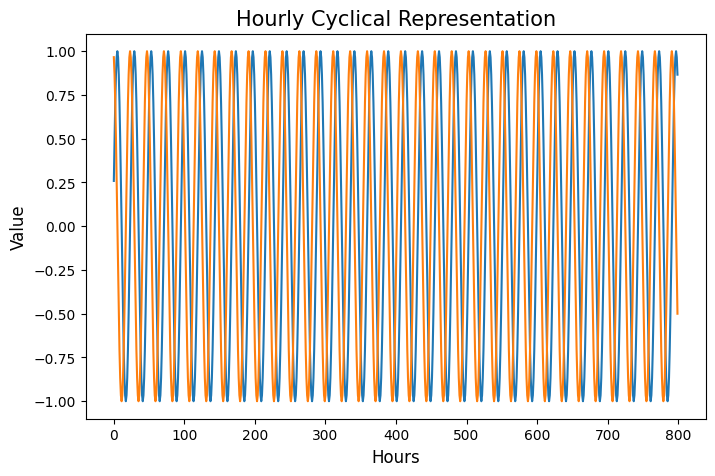

In [44]:
plt.figure(figsize=(8,5))
plt.plot(df_timestamped[f'sin_hour'][0:800])
plt.plot(df_timestamped[f'cos_hour'][0:800])
plt.title('Hourly Cyclical Representation',fontsize=15)
plt.xlabel('Hours', fontsize=12)
plt.ylabel('Value', fontsize=12)

Text(0, 0.5, 'Value')

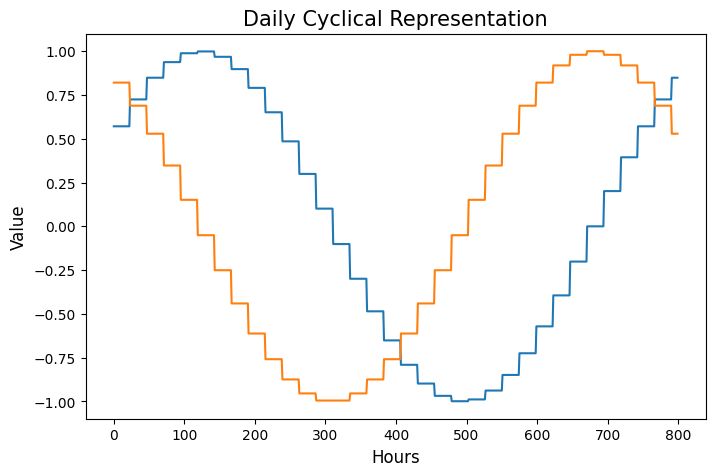

In [45]:
# each step represents a single day
plt.figure(figsize=(8,5))
plt.plot(df_timestamped[f'sin_day'][0:800])
plt.plot(df_timestamped[f'cos_day'][0:800])
plt.title('Daily Cyclical Representation',fontsize=15)
plt.xlabel('Hours', fontsize=12)
plt.ylabel('Value', fontsize=12)

Text(0, 0.5, 'Value')

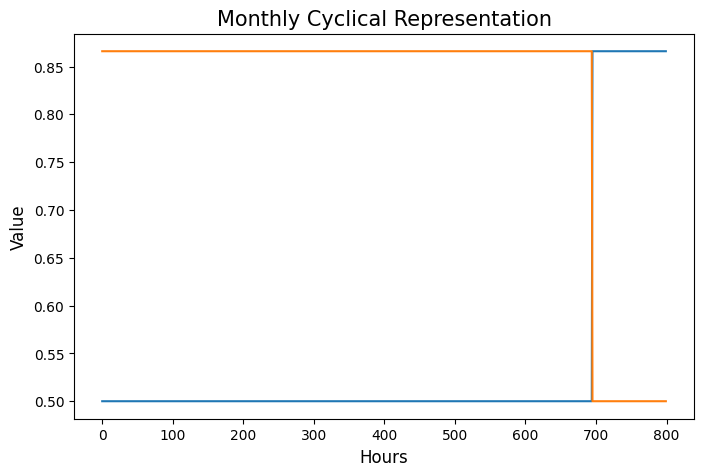

In [46]:
plt.figure(figsize=(8,5))
plt.plot(df_timestamped[f'sin_month'][0:800]) #average number of hours in a month ~730 hours, should visualize one month and some more
plt.plot(df_timestamped[f'cos_month'][0:800])
plt.title('Monthly Cyclical Representation',fontsize=15)
plt.xlabel('Hours', fontsize=12)
plt.ylabel('Value', fontsize=12)

## Define Dataloaders

In [28]:
class GetEnergyLoad():
    '''
    This data class loads the Panama dataset located at /Data and first splits the dataframe by the proportions
    defined in the init function (dev_split and test_split). In this case, the test_split is the proportion associated
    with the hold-out or unseen data set. The class then encodes the timestamps associated with each row in the dataframe
    and adds those embeddings as additional features. The process_data function then calls on the "get_avg" function within the 
    class that averages the weather features across the three cities for each timestep in the dataset. The weather
    feature averaging is done because the load values in the dataset represent the national load that includes all three
    cities within the dataset. Finally, when the dataset is called, the "__getitem__" function will normalize each feature
    to range (-1,1) and save the normalization transformation to a joblib file for future non-normalization in the 
    final test case.
    '''

    def __init__(self,
                 encode_cyclical = False,
                 dev_split = 0.3,  
                 test_split= 0.1,
                 forecast_window = 24, 
                 seq_len = 48,
                 type='Train',
                 data_lim = 1000,
                 save=True):
        
        """
        :param encode_cyclical: (bool) if True, will encode the timestamps associated with each time-series data point
        :param dev_split: (float) proportion of the validation set
        :param test_split: (float) proportion of the test set (unseen data)
        :param forecast_window: (int) number of timesteps (in hours) for future window prediction
        :param seq_len: (int) length of historical window to model
        :param type: (str) options: Train, Dev, Test
        :param data_lim: (int) define the subset of data you will like to use, will only use df[0:data_lim]
        :param save: (bool) if True, will save each split into CSV files in save_path dir
    
        """
        

        self.save_path = ''
        self.read_data()
        self.df = self.df[0:data_lim] #only taking subset of data to decrease memory
        
        self.transform = MinMaxScaler((-1,1)) #normalizes data to range (-1,1)
        self.forecast_window = forecast_window
        self.seq_len = seq_len #historical input data 
        self.dev_slice = int(len(self.df) * dev_split)
        self.test_slice = int(len(self.df) * test_split)
        self.train_slice = int(len(self.df) * (1-(dev_split+test_split)))
        self.data_type = type
        self.save_df = save
        self.name = type.lower()

        if self.data_type == 'Train':
            self.df = self.df[:self.train_slice] #data= df[0:training split]
        
        elif self.data_type == 'Dev':
            self.df = self.df[self.train_slice:self.train_slice+self.dev_slice] #data= df[training_split - training_split+dev_split]
            self.df = self.df.reset_index()

        elif self.data_type == 'Test':
            self.df = self.df[-self.test_slice:]#data = last (test_slice) values in dataframe
            self.df = self.df.reset_index()
            

        self.timestamps = self.df['datetime']
        assert ptypes.is_datetime64_any_dtype(self.df['datetime']) #datetime column must be a pandas timestamp
        
        if encode_cyclical:
            self.process_data()

    def read_data(self):
        # URL of the building measurements CSV file
        url = "https://data.mendeley.com/public-files/datasets/byx7sztj59/files/94ef3285-7ce4-43e2-9fd3-9cb3f592b89c/file_downloaded"
        
        # Download the file
        response = requests.get(url)
        with open("continuous dataset.csv", "wb") as file:
            file.write(response.content)
        
        self.df = pd.read_csv("continuous dataset.csv",parse_dates=['datetime'])
    
    def process_data(self):
        '''
        Encode the datetime timestamps associated with each data point into cyclical data 
        '''
        
        timestamps_hour = np.array([float(t.hour) for t in self.timestamps])
        timestamps_day = np.array([float(t.day) for t in self.timestamps])
        timestamps_month = np.array([float(t.month) for t in self.timestamps])
        
        hours_in_day = 24
        days_in_month = 31 #max number of days/month
        months_in_year = 12
    
        self.df['sin_hour'] = np.sin(2*np.pi*timestamps_hour/hours_in_day)
        self.df['cos_hour'] = np.cos(2*np.pi*timestamps_hour/hours_in_day)
        self.df['sin_day'] = np.sin(2*np.pi*timestamps_day/days_in_month)
        self.df['cos_day'] = np.cos(2*np.pi*timestamps_day/days_in_month)
        self.df['sin_month'] = np.sin(2*np.pi*timestamps_month/months_in_year)
        self.df['cos_month'] = np.cos(2*np.pi*timestamps_month/months_in_year)
    
        self.get_avg()
        
    def get_average(self,x,y,z):
        return np.mean((x,y,z))

    def get_avg(self):
        '''
        Takes the average of the following four features per hour across three cities in Panama:
        T2M: Temperature at 2 meters in each city (ºC)
        QVSM: Relative humiditiy at 2 meters in each city (%)
        TQL: Liquid precipitation in each city (liters/m2)
        W2M: Wind speed at 2 meters in each city (m/s)
        
        '''
        feature_cols = ['T2M_toc','QV2M_toc','TQL_toc','W2M_toc', #Tocumen, Panama city 
                        'T2M_san','QV2M_san','TQL_san','W2M_san', #Santiago City
                        'T2M_dav','QV2M_dav','TQL_dav','W2M_dav'] #David city
        
        features = [i for i in self.df.columns if i in feature_cols]
        df_chopped = self.df[features]
        
        self.df['T2M_avg'] = df_chopped.apply(lambda row: self.get_average(row['T2M_toc'],row['T2M_san'], row['T2M_dav']), axis=1)
        self.df['QV2M_avg'] = df_chopped.apply(lambda row: self.get_average(row['QV2M_toc'],row['QV2M_san'], row['QV2M_dav']), axis=1)
        self.df['TQL_avg'] = df_chopped.apply(lambda row: self.get_average(row['TQL_toc'],row['TQL_san'], row['TQL_dav']), axis=1)
        self.df['W2M_avg'] = df_chopped.apply(lambda row: self.get_average(row['W2M_toc'],row['W2M_san'], row['W2M_dav']), axis=1)

        self.df = self.df[['datetime','nat_demand','T2M_avg','QV2M_avg','TQL_avg', 'W2M_avg',
            'sin_hour','cos_hour','sin_day','cos_day','sin_month','cos_month']]

        if self.save_df:
            self.df.to_csv(self.save_path + f'{self.data_type}_dataset.csv', index=False)
            print(f'saved {self.data_type}_dataset.csv at {self.save_path}')

    def normalize(self, norm_idx, _input,  name=''):
        '''
        Normalizes the load feature to range (0,1)

        :param norm_idx: (int) dimension to normalize (each dimension is associated with each feature)
        :param _input: (tensor) input data
        :param target: (tensor) input data that is shifted to include the forecast window
        :param name: (str) name of feature to save the scalar item to unnormalize data later
        '''
        scaler = self.transform

        scaler.fit(_input[:,norm_idx].unsqueeze(-1))
        _input[:,norm_idx] = torch.tensor(scaler.transform(_input[:,norm_idx].unsqueeze(-1)).squeeze(-1))

        # save the scalar to be used later when inverse translating the data for plotting.
        dump(scaler, f'{name}_scalar_item.joblib')

        return  _input

    def __len__(self):
        return len(self.df)
    
    def collate_fn(self, batch):
        """Wraps the default PyTorch batch collation function and adds a name field.

        :param batch: (dict str: torch.Tensor) dataset sample.
        """
        batch = default_collate(batch)
        batch['name'] = self.name
        return batch
        
    def __getitem__(self, idx):
    
        # np.random.seed(0) #for reproducability

        start = np.random.randint(0, len(self.df) - self.seq_len- self.forecast_window) #choose a random starting point for window
        _input = torch.tensor(self.df[['nat_demand','T2M_avg','QV2M_avg','TQL_avg', 'W2M_avg',
                                       "sin_hour", "cos_hour", "sin_day","cos_day", "sin_month", "cos_month"]]
                              [start : start + self.seq_len].values) #slice input data by the seq len
        forecast = torch.tensor(self.df[['nat_demand','T2M_avg','QV2M_avg','TQL_avg', 'W2M_avg',
                                        "sin_hour", "cos_hour", "sin_day","cos_day", "sin_month", "cos_month"]]
                      [start + self.seq_len : start + self.seq_len + self.forecast_window].values) #slice input data by the seq len

        for i, col in enumerate(self.df[['nat_demand','T2M_avg','QV2M_avg','TQL_avg', 'W2M_avg']]):
            _input = self.normalize(i, _input,name=col) #normalizes all features except time features since time is already scaled
            if i == 0:
                forecast = self.normalize(i, forecast, name=col)
            else:
                pass

        src = _input.double()[:-1,:] #drops last element so input = t1-t47
        forecast = forecast.double() #forecast = t48-t72
        recon = _input.double()[1:,:] # shifts src by one

        if self.name == 'test':
            return {'X':src,'Y':recon, 'Z':forecast, 'name':self.name}
        else:
            return{'X':src,'Y':recon, 'Z':forecast}

In [29]:
train_data = GetEnergyLoad(encode_cyclical=True,seq_len=72, type='Train')
train_dataloader = DataLoader(train_data,  collate_fn = train_data.collate_fn, shuffle=True)

dev_data = GetEnergyLoad(encode_cyclical=True,seq_len=72, type='Dev')
dev_dataloader = DataLoader(dev_data, collate_fn = dev_data.collate_fn, shuffle=True)

test_data = GetEnergyLoad(encode_cyclical=True, seq_len=72 ,type='Test')
test_dataloader = DataLoader(test_data,  collate_fn = dev_data.collate_fn, shuffle=True)

saved Train_dataset.csv at 
saved Dev_dataset.csv at 
saved Test_dataset.csv at 


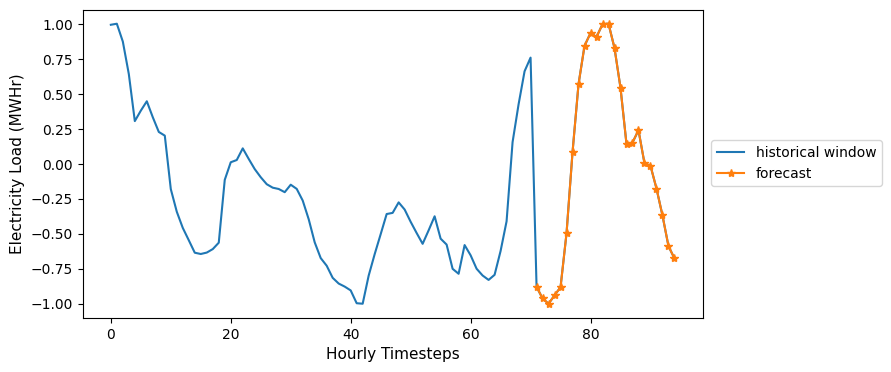

In [30]:
src = train_data[0]['X'].permute(1,0)[0]
forecast = train_data[0]['Z'].permute(1,0)[0]
seq_len = 72 #historical window
forecast_window = 24

plt.figure(figsize=(8,4))
plt.plot(torch.cat((src, forecast)).detach().numpy(), label='historical window') #historical window = t1-t71
plt.plot(np.arange(seq_len-1, seq_len+forecast_window-1, 1), forecast.detach().numpy(), #shift, forecast = t72-t96
         label='forecast',
         marker='*')
plt.ylabel('Electricity Load (MWHr)', fontsize=11)
plt.xlabel('Hourly Timesteps', fontsize=11)
plt.legend(bbox_to_anchor=(1.3,0.6))

## Model

In [5]:
device='cpu'
transformer_model = blocks.Transformer(insize = 11, #feature size = 11
                 outsize = 1, #we want the final prediction to be the same dim as the load
                 num_heads = 11, #up to user to decide, but let's give each feature it's own attention head
                 dropout=0.01,
                bias=True,
                hsizes=3).double().to(device) #inputs are of dtype double, model must be too

/usr/local/anaconda3/envs/neuro/lib/python3.10/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [6]:
transformer_model

Transformer(
  (encoder_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=11, out_features=11, bias=True)
    )
    (linear1): Linear(in_features=11, out_features=2048, bias=True)
    (dropout): Dropout(p=0.01, inplace=False)
    (linear2): Linear(in_features=2048, out_features=11, bias=True)
    (norm1): LayerNorm((11,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((11,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.01, inplace=False)
    (dropout2): Dropout(p=0.01, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=11, out_features=11, bias=True)
        )
        (linear1): Linear(in_features=11, out_features=2048, bias=True)
        (dropout): Dropout(p=0.01, inplace=False)
        (l

In [7]:
def slice_load(Y):
    '''
    Slices the target label to only the load dimension
    '''
    if Y.dim() <= 2: # in inference, shape does not include batch size
        return Y[:,0].unsqueeze(-1)
    else:
        return Y[:,:,0].unsqueeze(-1) #slice along the load dimension



node_1 = Node(slice_load, ['Y'], ['Y_sliced'], name='slice load') #only compare the load feature to the output of decoder
transformer= Node(transformer_model, ['X'],['predicted'], name = 'Transformer')

nodes = [node_1, transformer] #slice the target to load dim, then pass inputs into model

predicted = variable('predicted')
Y_sliced = variable('Y_sliced')

#we choose a MSE loss function to assess the quality of a model's predictions by measuring how closely they align with the ground truth.
MSE = (Y_sliced == predicted)^2
MSE.name='Mean Squared Error'


constraints = []
objectives = [MSE] 


# create constrained optimization loss
loss_ = PenaltyLoss(objectives, constraints)
# construct constrained optimization problem
problem = Problem(nodes, loss_)

# create constrained optimization loss
loss = PenaltyLoss(objectives, constraints)
optimizer = torch.optim.Adam(transformer_model.parameters(), lr=0.005) #we choose the Adam optimizer because it reports to have a faster convergence and little memory requirements

batch_size = 2
logger = BasicLogger(args=None, savedir='test', verbosity=1,
                        stdout=['dev_loss', 'train_loss'])


None


In [8]:
problem

### MODEL SUMMARY ###

nodeS:
  slice load(Y) -> Y_sliced
  Transformer(X) -> predicted

CONSTRAINTS: none

OBJECTIVES:
  Constraint(
  (left): Y_sliced
  (right): predicted
  (comparator): Eq()
)

In [9]:
# problem.show()

# Initiate Trainer

In [10]:
trainer = Trainer(
    problem,
    train_dataloader,
    dev_dataloader,
    test_dataloader,
    optimizer,
    patience=100,
    warmup=500,
    epochs=3,
    eval_metric="dev_loss",
    train_metric="train_loss",
    dev_metric="dev_loss",
    test_metric="dev_loss",
    logger=logger,
)

Number of parameters: 190760


In [11]:
best_model_transformer = trainer.train()
problem.load_state_dict(best_model_transformer)

epoch: 0	train_loss: 0.00865	dev_loss: 0.01234	eltime:  36.46186
epoch: 1	train_loss: 0.00854	dev_loss: 0.02316	eltime:  71.98736
epoch: 2	train_loss: 0.00613	dev_loss: 0.00925	eltime:  108.00256


<All keys matched successfully>

## Test on Unseen Data

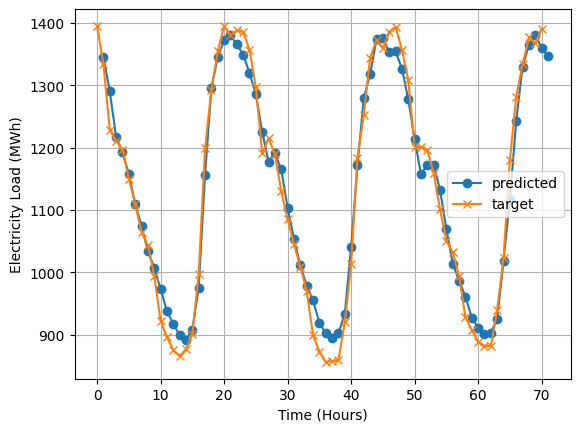

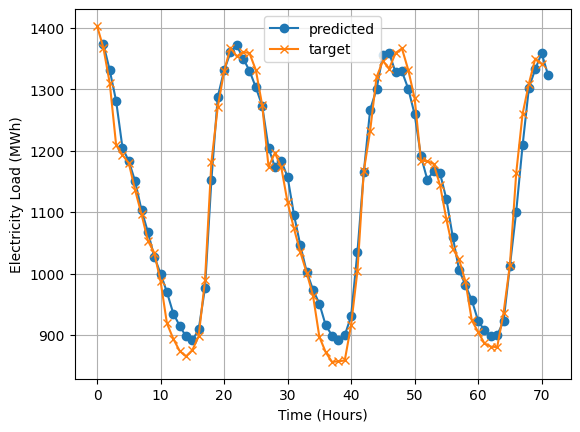

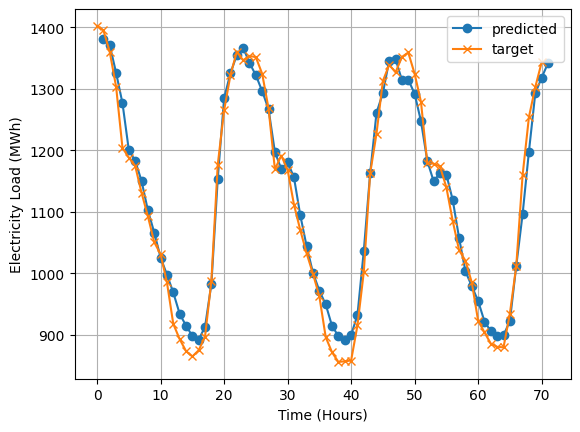

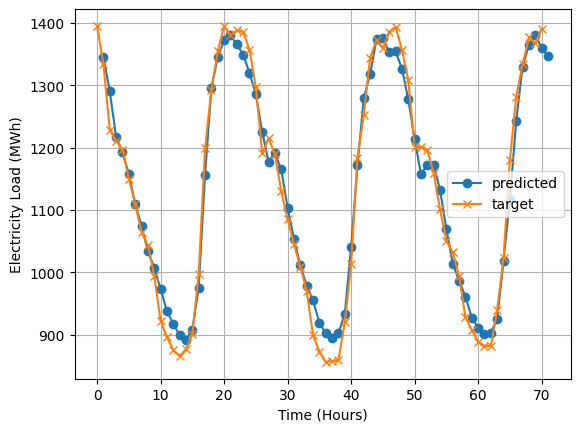

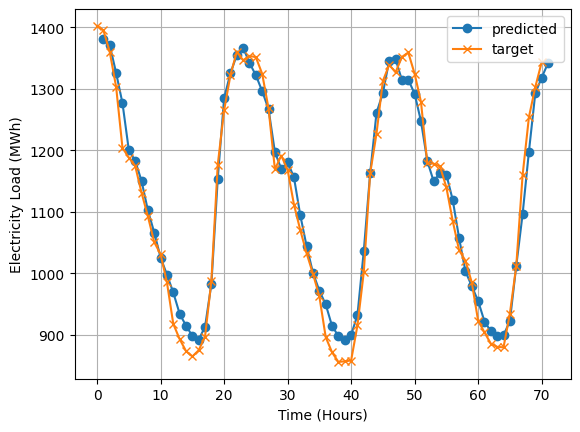

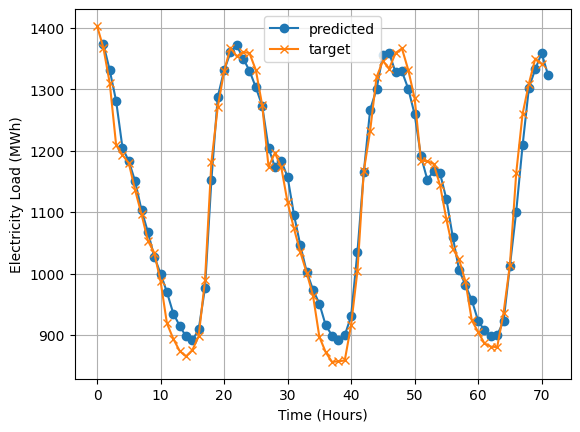

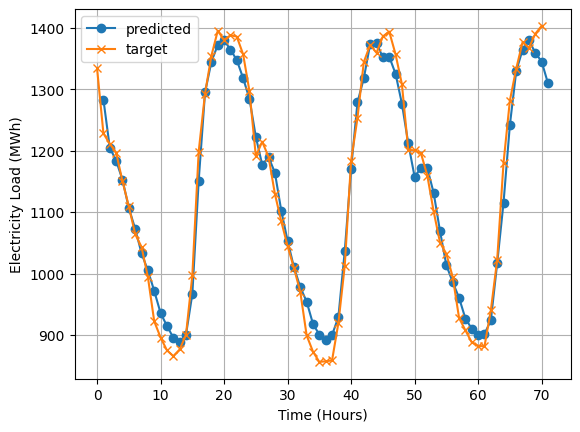

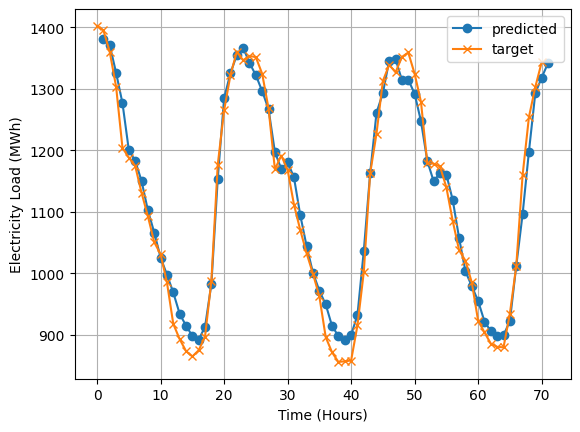

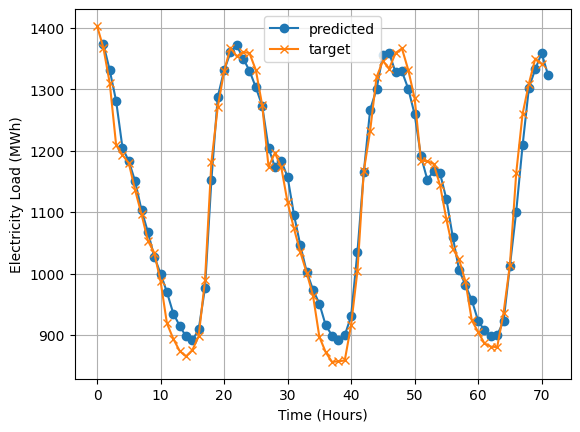

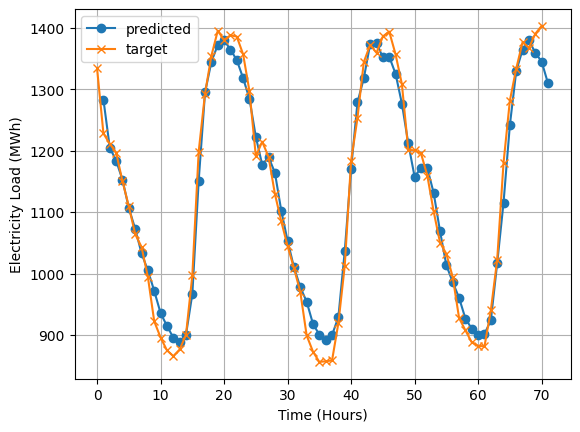

In [13]:
# see how well the trained model does on unseen data

for i in range(10):
    with torch.no_grad():
        test_outputs = problem(test_data[i])
    
    
        scaler = load('nat_demand_scalar_item.joblib') #scalar for normalizing the load
        src_load = scaler.inverse_transform(test_outputs['test_X'][:,0].cpu().reshape(1, -1)) #unnormalize
        prediction_load = scaler.inverse_transform(test_outputs['test_predicted'][:,0].cpu().reshape(1, -1)) #unnormalize
        
        
        plt.plot(np.arange(1,len(src_load[0])+1,1),prediction_load[0], marker='o', label='predicted') 
        plt.plot(np.arange(0,len(src_load[0]),1),src_load[0] , marker='x', label='target')
        #plt.title(title)
        plt.xlabel('Time (Hours)')
        plt.ylabel('Electricity Load (MWh)')
        plt.legend()
        plt.grid(True)
        plt.show()